In [1]:
# ============================================================
#  YOLO LABEL GENERATOR  —  VehiDE (Polygon ➜ YOLO txt)
#  -----------------------------------------------------------
#  • Works on YOUR local cache folder or any custom root
#  • Skips work that’s already done  (idempotent & resumable)
#  • Uses fast NumPy math + lightweight Pillow metadata reads
#  • Multithreaded for I/O-bound image size look-ups
# ============================================================

import os, json, hashlib, concurrent.futures, functools, time
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm.auto import tqdm            # progress bar (optional)

# ------------------------------------------------------------------------
# 1)  CONFIG  – adapt only ROOT if your cache path ever changes
# ------------------------------------------------------------------------
ROOT   = Path.home() / ".cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1"
OUTDIR = ROOT / "yolo_dataset" / "labels"                    # where *.txt files will go
N_WORKERS = 8                                    # threads for image-size I/O

CLASSES = {              # 0-based mapping
    'mat_bo_phan': 0,
    'rach':        1,
    'mop_lom':     2,
    'tray_son':    3,
    'thung':       4,
    'vo_kinh':     5,
    'be_den':      6
}

# ------------------------------------------------------------------------
# 2)  HELPERS
# ------------------------------------------------------------------------
def clip01(x: float) -> float:
    """Round to 6 dec places and clamp to (0,1)."""
    return max(0., min(1., round(x, 6)))

@functools.lru_cache(maxsize=2048)
def get_img_size(path: str) -> tuple[int, int]:
    """Fast width/height getter with per-process LRU cache."""
    with Image.open(path) as im:
        return im.size   # (w, h)

def polygon_to_yolo(all_x, all_y, img_w, img_h):
    x_min, x_max = np.min(all_x), np.max(all_x)
    y_min, y_max = np.min(all_y), np.max(all_y)
    w, h = x_max - x_min, y_max - y_min
    x_c = clip01((x_min + w/2) / img_w)
    y_c = clip01((y_min + h/2) / img_h)
    return x_c, y_c, clip01(w/img_w), clip01(h/img_h)

def process_image(args):
    img_path, img_data, out_path = args
    if out_path.exists():          # ✅ cached
        return
    try:
        img_w, img_h = get_img_size(str(img_path))
    except Exception:
        return                     # corrupted / unreadable
    lines = []
    for reg in img_data.get("regions", []):
        cls = reg.get("class")
        if cls not in CLASSES:
            continue
        x_c, y_c, w_n, h_n = polygon_to_yolo(
            np.array(reg["all_x"]), np.array(reg["all_y"]), img_w, img_h
        )
        lines.append(f"{CLASSES[cls]} {x_c} {y_c} {w_n} {h_n}")
    if lines:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        out_path.write_text("\n".join(lines))

def convert_split(img_dir: Path, anno_json: Path, split_name: str):
    with anno_json.open() as f:
        annos = json.load(f)

    tasks = []
    for img_name, img_data in annos.items():
        img_path  = img_dir / img_name
        out_path  = OUTDIR / split_name / f"{img_path.stem}.txt"
        if img_path.exists():
            tasks.append((img_path, img_data, out_path))

    print(f"↪ Converting {split_name}: {len(tasks):,} images …")

    # Multithreaded execution – image size I/O is the bottleneck
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_WORKERS) as ex:
        list(tqdm(ex.map(process_image, tasks), total=len(tasks)))

    print(f"✔ Done {split_name}. Labels saved under {OUTDIR/split_name}")

# ------------------------------------------------------------------------
# 3)  RUN  (train + val)   — safe to re-run; only new/changed files process
# ------------------------------------------------------------------------
start = time.time()
convert_split(ROOT/"image/image",            ROOT/"0Train_via_annos.json", "train")
convert_split(ROOT/"validation/validation",  ROOT/"0Val_via_annos.json",   "val")
print(f"🏁 Finished in {time.time()-start:.1f}s")

/opt/anaconda3/envs/yolo8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


↪ Converting train: 11,621 images …


100%|██████████| 11621/11621 [00:00<00:00, 305213.63it/s]


✔ Done train. Labels saved under /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/labels/train
↪ Converting val: 2,324 images …


100%|██████████| 2324/2324 [00:00<00:00, 182716.55it/s]

✔ Done val. Labels saved under /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/labels/val
🏁 Finished in 0.5s


In [2]:
# ===============================================================
#   BUILD YOLO-READY DATASET  (images + labels in one go)
#   -------------------------------------------------------------
#   • Mirrors images (symlink by default, change link=False to copy)
#   • Converts VehiDE VIA polygons → YOLO txt labels
#   • Works idempotently: re-run and it touches only what’s new
# ===============================================================

from pathlib import Path
import os, json, shutil, functools, concurrent.futures, numpy as np
from PIL import Image
from tqdm.auto import tqdm

# ─── CONFIG ────────────────────────────────────────────────────
ROOT = Path.home() / ".cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1"

YOLO_ROOT   = ROOT / "yolo_dataset"                # 🔸 final dataset folder
IMG_TRAIN_S = ROOT / "image" / "image"
IMG_VAL_S   = ROOT / "validation" / "validation"
N_WORKERS   = 8
LINK_IMAGES = True                                 # symlink instead of copy

CLASSES = {
    'mat_bo_phan': 0, 'rach': 1, 'mop_lom': 2,
    'tray_son': 3,   'thung': 4, 'vo_kinh': 5, 'be_den': 6
}

# ─── HELPERS ───────────────────────────────────────────────────
def clip01(x): return max(0., min(1., round(x, 6)))

@functools.lru_cache(maxsize=2048)
def img_size(p):
    with Image.open(p) as im: return im.size

def poly2yolo(xs, ys, w, h):
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    bw, bh = x_max - x_min, y_max - y_min
    return (clip01((x_min + bw/2)/w), clip01((y_min + bh/2)/h),
            clip01(bw/w), clip01(bh/h))

def make_dirs():
    (YOLO_ROOT/"images/train").mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT/"images/val").mkdir(parents=True,   exist_ok=True)
    (YOLO_ROOT/"labels/train").mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT/"labels/val").mkdir(parents=True,   exist_ok=True)

def mirror_images(src, dst, link=True):
    for p in src.iterdir():
        if p.suffix.lower() not in {".jpg", ".jpeg", ".png"}: continue
        tgt = dst/p.name
        if tgt.exists(): continue
        if link:
            try: tgt.symlink_to(p.resolve()); continue
            except OSError: pass
        shutil.copy2(p, tgt)

def build_labels(img_dir, anno_json, lbl_dir):
    with open(anno_json) as f: annos = json.load(f)
    tasks=[]
    for fname,data in annos.items():
        ip = img_dir/fname ; op = lbl_dir/f"{Path(fname).stem}.txt"
        if not ip.exists() or op.exists(): continue
        tasks.append((ip, data, op))
    def work(t):
        ip,data,op=t
        try: iw,ih=img_size(ip)
        except: return
        lines=[]
        for r in data.get("regions",[]):
            cls=r["class"]; 
            if cls not in CLASSES: continue
            xc,yc,wn,hn = poly2yolo(np.array(r["all_x"]), np.array(r["all_y"]), iw, ih)
            lines.append(f"{CLASSES[cls]} {xc} {yc} {wn} {hn}")
        if lines: op.write_text("\n".join(lines))
    with concurrent.futures.ThreadPoolExecutor(N_WORKERS) as ex:
        list(tqdm(ex.map(work,tasks), total=len(tasks)))

# ─── EXECUTE ───────────────────────────────────────────────────
make_dirs()

print("📁 Mirroring images …")
mirror_images(IMG_TRAIN_S, YOLO_ROOT/"images/train", LINK_IMAGES)
mirror_images(IMG_VAL_S,   YOLO_ROOT/"images/val",   LINK_IMAGES)

print("✏️  Generating labels …")
build_labels(IMG_TRAIN_S, ROOT/"0Train_via_annos.json", YOLO_ROOT/"labels/train")
build_labels(IMG_VAL_S,   ROOT/"0Val_via_annos.json",   YOLO_ROOT/"labels/val")

print("\n✅ YOLO dataset ready at:", YOLO_ROOT)
print("   images/train:", len(list((YOLO_ROOT/'images/train').glob('*'))),
      "| labels/train:", len(list((YOLO_ROOT/'labels/train').glob('*'))))
print("   images/val:  ", len(list((YOLO_ROOT/'images/val').glob('*'))),
      "| labels/val:  ", len(list((YOLO_ROOT/'labels/val').glob('*'))))

📁 Mirroring images …
✏️  Generating labels …


0it [00:00, ?it/s]
0it [00:00, ?it/s]



✅ YOLO dataset ready at: /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset
   images/train: 23228 | labels/train: 11621
   images/val:   4646 | labels/val:   2324


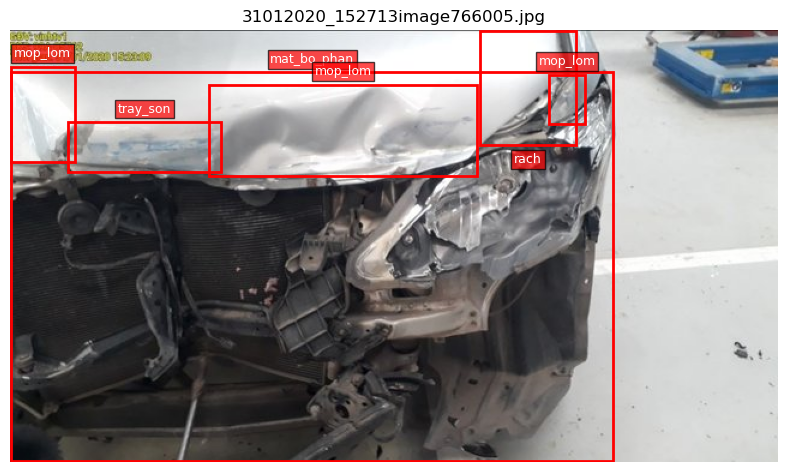

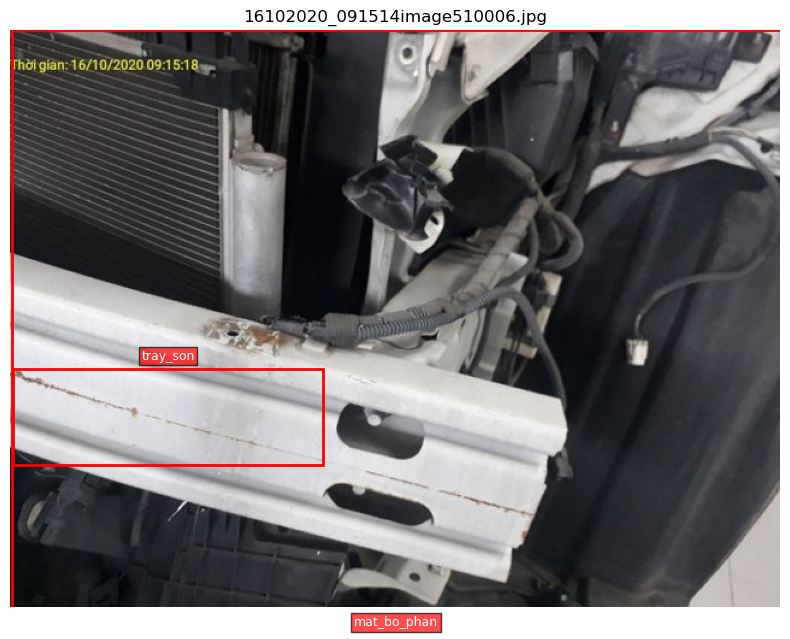

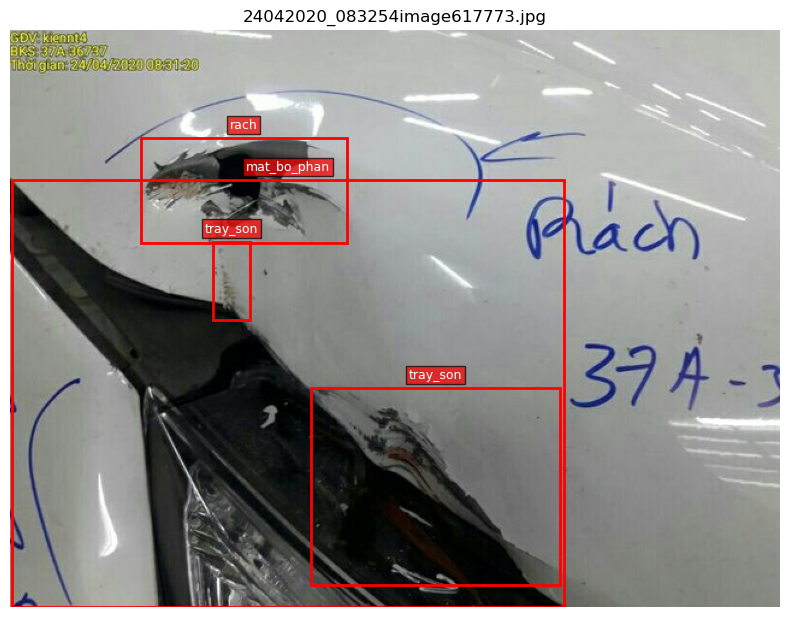

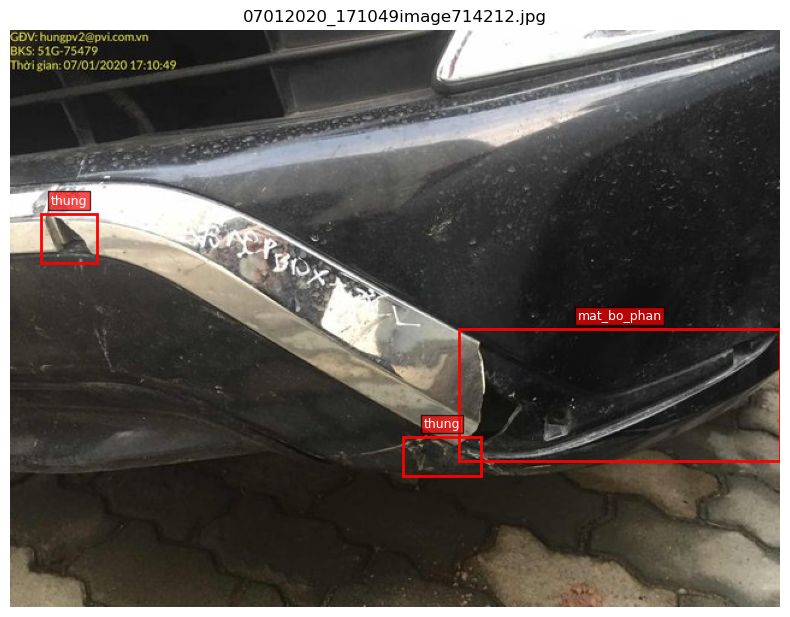

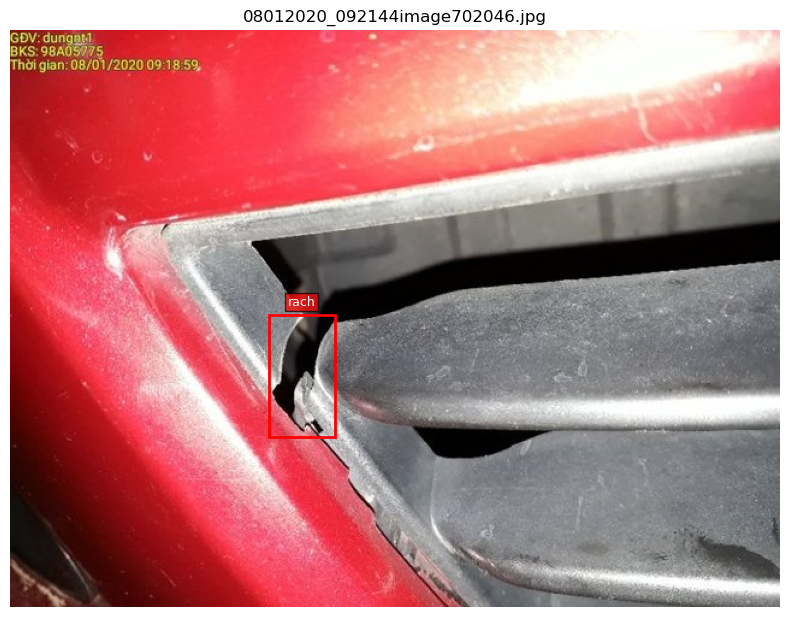

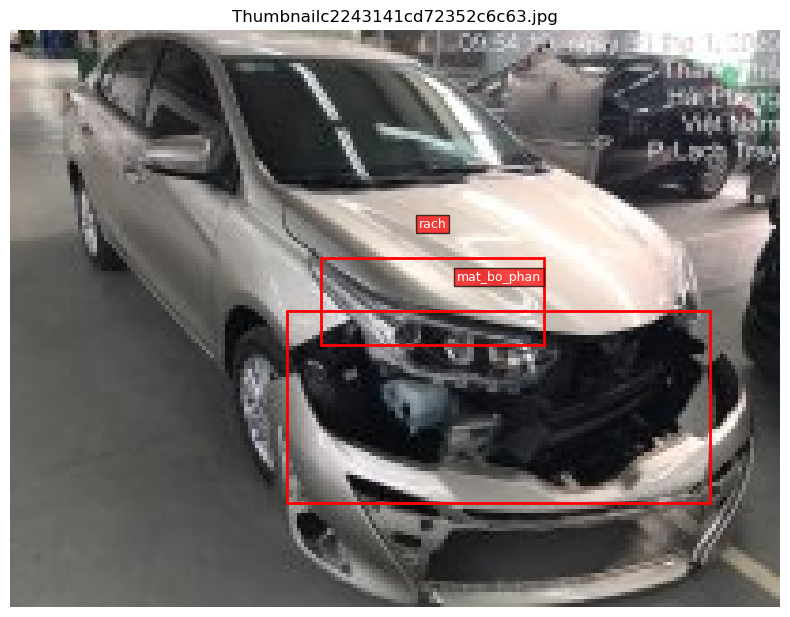

In [3]:
# ============================================================
#  Quick visual check of random YOLO-labelled images
# ============================================================

from pathlib import Path
import random, os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# ─── CONFIG ──────────────────────────────────────────────────
DATASET_ROOT = Path.home() / ".cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset"
SPLIT        = "train"     # "train" or "val"
NUM_SAMPLES  = 6           # how many random images to display

CLASS_NAMES = {
    0: "mat_bo_phan", 1: "rach", 2: "mop_lom",
    3: "tray_son",    4: "thung",5: "vo_kinh", 6: "be_den"
}

# ─── GATHER FILES ────────────────────────────────────────────
img_dir = DATASET_ROOT / "images" / SPLIT
lbl_dir = DATASET_ROOT / "labels" / SPLIT
imgs    = [p for p in img_dir.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png"}]

assert imgs, f"No images found in {img_dir}"
sampled = random.sample(imgs, min(NUM_SAMPLES, len(imgs)))

# ─── VISUALISE ───────────────────────────────────────────────
for img_path in sampled:
    lbl_path = lbl_dir / f"{img_path.stem}.txt"

    image = Image.open(img_path).convert("RGB")
    W, H  = image.size

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(img_path.name)

    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            parts = line.strip().split()
            if len(parts) != 5: continue
            cls, xc, yc, bw, bh = map(float, parts)

            x1 = (xc - bw/2) * W
            y1 = (yc - bh/2) * H
            box_w, box_h = bw * W, bh * H

            rect = patches.Rectangle(
                (x1, y1), box_w, box_h,
                linewidth=2, edgecolor="red", facecolor="none"
            )
            plt.gca().add_patch(rect)

            label = CLASS_NAMES.get(int(cls), str(int(cls)))
            plt.text(
                x1 + box_w/2,
                y1 - 8 if y1 > 15 else y1 + box_h + 15,
                label,
                fontsize=9, color="white", ha="center",
                bbox=dict(facecolor="red", alpha=0.7, pad=2),
            )

    plt.tight_layout()
    plt.show()

NameError: name 'visualize_yolo_annotations' is not defined

In [4]:

import ultralytics
ultralytics.checks()

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0 CPU (Apple M4)
Setup complete ✅ (10 CPUs, 24.0 GB RAM, 343.5/926.4 GB disk)


In [5]:
# -------------------------------------------------------------
#  Fault-tolerant shrink + recompress
# -------------------------------------------------------------
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm
import concurrent.futures, os, logging

DATASET_ROOT = Path.home() / ".cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset"
SRC_DIR = DATASET_ROOT / "images"
DST_DIR = DATASET_ROOT / "images_640"
TARGET_SIZE = (640, 640)
QUALITY = 85

bad_files = []                        # collect paths that fail

def shrink_safe(img_path: Path):
    try:
        rel  = img_path.relative_to(SRC_DIR)
        out  = DST_DIR / rel
        out.parent.mkdir(parents=True, exist_ok=True)

        if out.exists() and out.stat().st_size:
            return

        with Image.open(img_path) as im:
            im = im.convert("RGB")
            im.thumbnail(TARGET_SIZE, Image.LANCZOS)
            im.save(out, "JPEG", quality=QUALITY, optimize=True)

    except (OSError, UnidentifiedImageError) as e:
        bad_files.append(str(img_path))

images = [p for p in SRC_DIR.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}]
print(f"⚙️  Processing {len(images):,} images …")

with concurrent.futures.ThreadPoolExecutor(os.cpu_count()) as ex:
    list(tqdm(ex.map(shrink_safe, images), total=len(images), desc="Shrink"))

if bad_files:
    logging.warning("⚠️  %d files skipped due to errors (see list below)", len(bad_files))
    for bf in bad_files:
        logging.warning("   %s", bf)
else:
    print("✅ All images processed without errors.")

print("Done. Point data.yaml to images_640/* when you’re ready.")

⚙️  Processing 13,945 images …


Shrink: 100%|██████████| 13945/13945 [00:00<00:00, 78303.90it/s] 


Done. Point data.yaml to images_640/* when you’re ready.


In [7]:
import os
import platform
import datetime
from ultralytics import YOLO

# -- ENV ------------------------------------------------------------
# Stabilize multiprocessing on macOS
os.environ["MPS_FOREACH"] = "2"

# -- PATHS & SETTINGS -----------------------------------------------
DATA_ROOT = "/Users/vinaykasa/.cache/kagglehub/datasets/" \
             "hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/" \
             "versions/1/yolo_dataset"
DATA_YAML = f"{DATA_ROOT}/data.yaml"
RUN_NAME = f"vehide_yolov8n_highprecision_{datetime.datetime.now():%Y%m%d_%H%M}"

# Select device
DEVICE = "mps" if platform.machine() == "arm64" else ("cuda" if os.getenv("CUDA_VISIBLE_DEVICES") else "cpu")

# DataLoader workers
NUM_WORKERS = 0 if DEVICE == "mps" else max(2, os.cpu_count() // 2)

# Batch size: tune based on memory (16 is a starting point for high-res imgs)
BATCH_SIZE = 16

# -- MODEL INITIALIZATION -------------------------------------------
model = YOLO("yolov8n.pt")  # pretrained detection model

# -- HIGH-PRECISION TRAINING ----------------------------------------
results = model.train(
    data=DATA_YAML,
    device=DEVICE,
    epochs=50,
    patience=20,           # early stop if no improvement
    imgsz=640,            # higher resolution for precision
    batch=BATCH_SIZE,
    workers=NUM_WORKERS,
    optimizer="AdamW",
    lr0=1e-4,               # lower initial learning rate
    lrf=0.01,               # final lr ratio
    weight_decay=0.01,
    warmup_epochs=3.0,
    cos_lr=True,
    half=True,              # mixed precision
    cache="Disk",          # cache images in memory
    augment=True,
    multi_scale=True,       # enable multiscale training
    save_period=5,
    project="yolo_highprecision",
    name=RUN_NAME,
    exist_ok=True,
)
print(f"✅ Training complete. Best checkpoint: {results.best}")

# -- VALIDATION -----------------------------------------------------
metrics = model.val(
    model=results.best,
    data=DATA_YAML,
    device="cpu",
    workers=NUM_WORKERS,
)
print(f"📊 Precision-focused mAP50-95: {metrics['metrics/mAP50-95']:.4f}")


New https://pypi.org/project/ultralytics/8.3.118 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=5, cache=Disk, device=mps, workers=0, project=yolo_highprecision, name=vehide_yolov8n_highprecision_20250427_1534, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False

train: Scanning /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/labels/train.cache... 11607 images, 0 backgrounds, 14 corrupt: 100%|██████████| 11621/11621 [00:00<?, ?it/s]

train: /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/images/train/02012020_082351image833616.jpg: ignoring corrupt image/label: image file is truncated (21 bytes not processed)
train: /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/images/train/04052020_152057image59498.jpg: ignoring corrupt image/label: broken data stream when reading image file
train: /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/images/train/04052020_152101image628633.jpg: ignoring corrupt image/label: broken data stream when reading image file
train: /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/images/train/04052020_152107image748519.jpg: ignoring corrupt image/label: image 


train: Caching images (9.5GB Disk): 100%|██████████| 11607/11607 [00:00<00:00, 120878.39it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 176.9±45.7 MB/s, size: 56.6 KB)



val: Scanning /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/labels/val.cache... 2322 images, 0 backgrounds, 2 corrupt: 100%|██████████| 2324/2324 [00:00<?, ?it/s]

val: /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/images/val/24032020_094730image64439.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: /Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/images/val/24032020_140438image435324.jpg: ignoring corrupt image/label: image file is truncated (83 bytes not processed)



val: Caching images (1.9GB Disk): 100%|██████████| 2322/2322 [00:00<00:00, 146319.52it/s]


Plotting labels to yolo_highprecision/vehide_yolov8n_highprecision_20250427_1534/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to yolo_highprecision/vehide_yolov8n_highprecision_20250427_1534
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      23.7G      1.801      3.673      1.859         34        640: 100%|██████████| 726/726 [46:58<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/73 [00:15<?, ?it/s]


NotImplementedError: The operator 'torchvision::nms' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash Unknown. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
from ultralytics import YOLO
import os, platform
DATA = "/Users/vinaykasa/.cache/kagglehub/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/versions/1/yolo_dataset/data.yaml"
DEVICE = "mps" if platform.machine() == "arm64" else "cpu"

model = YOLO("yolov8n.pt")  # swap to "yolov8n-seg.pt" or "rtdetr-r18.pt" as needed

results = model.train(
    data=DATA,
    epochs=50,
    imgsz=640,
    batch=32,
    device=DEVICE,
    workers=os.cpu_count(),
    optimizer="AdamW",
    lr0=1e-3,
    weight_decay=0.05,
    warmup_epochs=0.5,
    cos_lr=True,
    amp=True,
    cache="disk",
    mosaic=0.5,
    mixup=0.0,
    patience=10,
    project="/Users/vinaykasa/yolo_results",
    name="vehide_fast",
    save_period=10,
    exist_ok=True,
)

print("Best weights:", results.best)

In [ ]:
import glob
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# 1. Load your trained model
model = YOLO('/content/best_damage_detection.pt')  # Update path to your trained weights

# 2. Get all images from prediction folder
image_paths = glob.glob('/content/predictions/*.jpg') + \
              glob.glob('/content/predictions/*.jpeg') + \
              glob.glob('/content/predictions/*.png')

# 3. Class names (must match your training)
class_names = {
    0: 'mat_bo_phan',
    1: 'rach',
    2: 'mop_lom',
    3: 'tray_son',
    4: 'thung',
    5: 'vo_kinh',
    6: 'be_den'
}

# 4. Prediction and visualization function
def predict_and_visualize(image_path, conf_threshold=0.25):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_image = image.copy()

    # Run prediction
    results = model(image, conf=conf_threshold)

    # Create plot
    plt.figure(figsize=(12, 8))
    plt.imshow(orig_image)

    # Process results
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        confs = result.boxes.conf.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy().astype(int)

        for box, conf, class_id in zip(boxes, confs, class_ids):
            x1, y1, x2, y2 = map(int, box)

            # Draw bounding box
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                fill=False, edgecolor='red', linewidth=2, alpha=0.8
            ))

            # Label with class and confidence
            label = f"{class_names[class_id]}: {conf:.2f}"
            plt.text(
                x1, y1-10, label,
                color='white', fontsize=10,
                bbox=dict(facecolor='red', alpha=0.8, edgecolor='none')
            )

    plt.axis('off')
    plt.title(f"Predictions: {image_path.split('/')[-1]}")
    plt.show()

    # Print detailed results
    print(f"\nFile: {image_path}")
    for class_id in class_names:
        class_mask = class_ids == class_id
        if any(class_mask):
            print(f"{class_names[class_id]}:")
            for conf in confs[class_mask]:
                print(f"  - Confidence: {conf:.2f}")

# 5. Run predictions on all images
for img_path in image_paths:
    predict_and_visualize(img_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/best_damage_detection.pt'